# Assignment 1: Sprint 2

## Sasha (Alexandra) Pukhova

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
# Set directory
import os 
os.chdir('data')

In [3]:
# Load data
data = pd.read_csv('train_eng_full.csv')
test = pd.read_csv('test_eng_full.csv')

/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = data[:-1]
test = test[:-1]
data.Holiday = data.Holiday.astype('int64')

In [5]:
# Encode the target 
cat_le = LabelEncoder()
cat_le.fit(data['Category'].unique())
data['Category']=cat_le.transform(data['Category'])
y_train = data['Category']

# Save our mapping
decoder = dict(zip(cat_le.transform(cat_le.classes_), cat_le.classes_))

In [6]:
print(data.shape)
print(test.shape)

(191636, 92)
(206946, 89)


In [7]:
X_train = data.drop(columns=(['Category','Address', 'Unnamed: 0', 'Unnamed: 0.1', 
                               'Unnamed: 0.1.1', 'Dates', 'Descript', 'DayOfWeek',
                               'Resolution','Enrolled In Public School', 'Enrolled In Private School',
                               'Not Enrolled In School' ]))

### Train/test split

In [8]:
y = y_train
features = X_train

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(172472, 80) (172472,)
(19164, 80) (19164,)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train) 

train_for_pca = scaler.transform(X_train)
test_for_pca = scaler.transform(X_test)

In [10]:
# Creating a dataframe to store the results of experiments

benchmark_cols = ['Variance retained','n_Components','Time(s)','Log_loss value']
lr_benchmark = pd.DataFrame(columns = benchmark_cols)
mlp_benchmark = pd.DataFrame(columns = benchmark_cols)

In [11]:
clfs = {'Log_reg':LogisticRegression(penalty='l1',
                                     C=1.5,
                                     solver='saga',
                                     max_iter=100,
                                     multi_class='multinomial', n_jobs=-1),
          'MLP':MLPClassifier(solver='lbfgs',
                       alpha=1e-5,
                       hidden_layer_sizes=(5, 2),
                       random_state=1)}

In [12]:
variance = 1.0
labels = list(range(0,39))

In [39]:
# Source code: (Foo, 2013) and (Kumar, 2018)

In [13]:
# Benchmark at 100% variance anf full number of features.
from itertools import repeat

def set_benchmark(clf, train_for_pca, test_for_pca, y_train, y_test, labels, benchmark):
    global benchmark_cols
    global variance
    
    n_components = train_for_pca.shape[1]
    clf = clf
    all_classes = labels
    
    start = time.time()
    clf.fit(train_for_pca, y_train)
    end = time.time()
    timing = end-start
    
    classes_not_trained = set(clf.classes_).symmetric_difference(all_classes)
    prob = clf.predict_proba(test_for_pca)

    for row in prob:
        prob_per_class = (list(zip(clf.classes_, prob))
                        + list(zip(classes_not_trained, repeat(0.))))

    logloss = log_loss(y_test, prob, labels=all_classes) 
    
    a = dict(zip(benchmark_cols,[variance,n_components,timing,logloss]))
    benchmark = benchmark.append(a,ignore_index=True)

    print(benchmark) 

In [14]:
set_benchmark(clfs['Log_reg'],train_for_pca,test_for_pca,y_train,y_test,labels,lr_benchmark)

/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   Variance retained  n_Components     Time(s)  Log_loss value
0                1.0          80.0  428.855759         2.45432


In [15]:
set_benchmark(clfs['MLP'],train_for_pca,test_for_pca,y_train,y_test,labels,mlp_benchmark)

   Variance retained  n_Components   Time(s)  Log_loss value
0                1.0          80.0  50.96498         2.48974


In [16]:
variance_list = [0.95,0.90,0.85,0.80,0.75,0.70] 

In [38]:
# Source code: (Kumar, 2018)

In [17]:
def pca(clf,variance,train_for_pca,y_train,test_for_pca,y_test,labels):
    pca = PCA(variance)
    pca.fit(train_for_pca)
    n_components = pca.n_components_
    train_for_pca = pca.transform(train_for_pca)
    test_for_pca = pca.transform(test_for_pca)
    
    clf = clf
    all_classes = labels
    start = time.time()
    clf.fit(train_for_pca, y_train)
    end =  time.time()
    timing = end-start   

    # Determine the classes that were not present in the training set
    classes_not_trained = set(clf.classes_).symmetric_difference(all_classes)
    prob = clf.predict_proba(test_for_pca)
    
    for row in prob:
        prob_per_class = (list(zip(clf.classes_, prob))
                        + list(zip(classes_not_trained, repeat(0.))))

    logloss = log_loss(y_test, prob, labels=all_classes) 
    
    return([variance,n_components,timing,logloss])

In [18]:
def add_to_table_lr(pca):
    global lr_benchmark
    global benchmark_cols
    a = dict(zip(benchmark_cols,pca))
    lr_benchmark = lr_benchmark.append(a,ignore_index=True)

In [19]:
def add_to_table_mlp(pca):
    #return
    global mlp_benchmark
    global benchmark_cols
    a = dict(zip(benchmark_cols,pca))
    mlp_benchmark = mlp_benchmark.append(a,ignore_index=True)

In [20]:
for variance in variance_list:
    pca_results = pca(clfs['Log_reg'],variance,train_for_pca,y_train,test_for_pca,y_test,labels)
    add_to_table_lr(pca_results)
    
print(lr_benchmark)

/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/sklearn/linear_model/sag.py:3

   Variance retained  n_Components     Time(s)  Log_loss value
0               0.95          25.0  129.510784        2.467025
1               0.90          21.0  113.611043        2.471851
2               0.85          17.0   93.165167        2.475747
3               0.80          14.0   85.911292        2.481265
4               0.75          11.0   72.853836        2.487809
5               0.70           8.0   55.285389        2.491070


In [21]:
lr_benchmark

,Variance retained,n_Components,Time(s),Log_loss value
0,0.95,25.0,129.510784,2.467025
1,0.90,21.0,113.611043,2.471851
2,0.85,17.0,93.165167,2.475747
3,0.80,14.0,85.911292,2.481265
4,0.75,11.0,72.853836,2.487809
5,0.70,8.0,55.285389,2.491070


In [31]:
init_data_0 = [] 
init_data_0.insert(0, {'Variance retained': 1.0, 'n_Components': 80.0, 'Time(s)': 428.855759, 'Log_loss value': 2.45432})

In [32]:
lr_new = pd.concat([pd.DataFrame(init_data_0), lr_benchmark], ignore_index=True)
lr_new

/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,Log_loss value,Time(s),Variance retained,n_Components
0,2.454320,428.855759,1.00,80.0
1,2.467025,129.510784,0.95,25.0
2,2.471851,113.611043,0.90,21.0
3,2.475747,93.165167,0.85,17.0
4,2.481265,85.911292,0.80,14.0
5,2.487809,72.853836,0.75,11.0
6,2.491070,55.285389,0.70,8.0


In [24]:
for variance in variance_list:
    pca_results_mlp = pca(clfs['MLP'],variance,train_for_pca,y_train,test_for_pca,y_test,labels)
    add_to_table_mlp(pca_results_mlp)

print(mlp_benchmark)

   Variance retained  n_Components    Time(s)  Log_loss value
0               0.95          25.0  48.768076        2.512736
1               0.90          21.0  15.786216        2.555348
2               0.85          17.0  49.686814        2.517085
3               0.80          14.0  51.914140        2.511712
4               0.75          11.0  56.506080        2.507105
5               0.70           8.0  54.092714        2.510727


In [25]:
mlp_benchmark

,Variance retained,n_Components,Time(s),Log_loss value
0,0.95,25.0,48.768076,2.512736
1,0.90,21.0,15.786216,2.555348
2,0.85,17.0,49.686814,2.517085
3,0.80,14.0,51.914140,2.511712
4,0.75,11.0,56.506080,2.507105
5,0.70,8.0,54.092714,2.510727


In [33]:
init_data = [] 
init_data.insert(0, {'Variance retained': 1.0, 'n_Components': 80.0, 'Time(s)': 50.96498 , 'Log_loss value': 2.48974})

In [34]:
mlp_new = pd.concat([pd.DataFrame(init_data), mlp_benchmark], ignore_index=True)
mlp_new

/Users/dns/anaconda/envs/CS146/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,Log_loss value,Time(s),Variance retained,n_Components
0,2.489740,50.964980,1.00,80.0
1,2.512736,48.768076,0.95,25.0
2,2.555348,15.786216,0.90,21.0
3,2.517085,49.686814,0.85,17.0
4,2.511712,51.914140,0.80,14.0
5,2.507105,56.506080,0.75,11.0
6,2.510727,54.092714,0.70,8.0


### Visualizing the results

In [35]:
def vis(benchmark):
    benchmark.plot(x=-2,y=0,style=['o','rx'])
    plt.title("Variance vs Log_loss score")
    
#     mlp_benchmark.plot(x=1,y=-1)
#     plt.title("Number of components vs Log_loss score")
    
    benchmark.plot(x=-3,y=0,style=['o','rx'])
    # plt.scatter
    plt.title("Running time vs Log_loss score")
    
    plt.show()

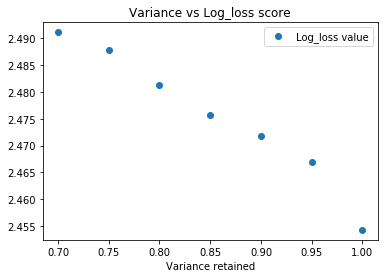

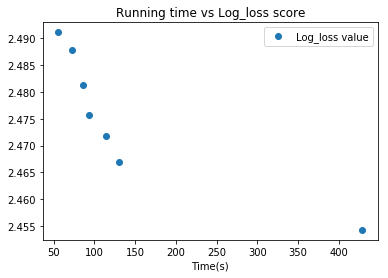

In [36]:
# Visualising the Logistic Regression results
vis(lr_new) 

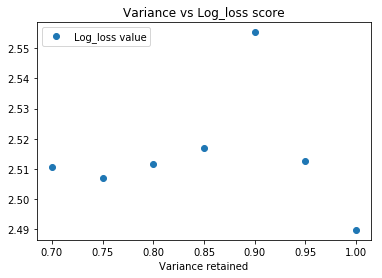

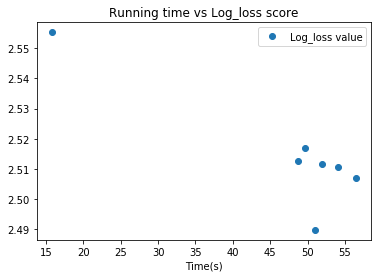

In [37]:
# Visualising MLP results
vis(mlp_new)

### Code references

Foo, F. (2013). Training a sklearn LogisticRegression classifier without all possible labels. Retrieved from https://stackoverflow.com/questions/15034664/training-a-sklearn-logisticregression-classifier-without-all-possible-labels.

Kumar, A. (2018, September 20). Logistic Regression with PCA Algorithm - A Guide with Example. Retrieved from https://acadgild.com/blog/logistic-regression-with-pca-algorithm.